In [87]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [36]:
# seq values 
row_count = 500
val_count = 100
test_count =100
N_LAGS =4

SPLIT_RATIOS = [0.80,0.10,0.10]
TRAIN_ROW_CNT = int(row_count*SPLIT_RATIOS[0])
VAL_ROW_CNT = int(row_count*SPLIT_RATIOS[1])
TEST_ROW_CNT = int(row_count*SPLIT_RATIOS[2])

val_st, val_end = TRAIN_ROW_CNT, N_LAGS+TRAIN_ROW_CNT+VAL_ROW_CNT

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })

for lag in range(1,N_LAGS+1):
    data[f'lag_{lag}'] = data['seq_values'].shift(lag)
data = data.dropna().reset_index(drop=True)

FEAT_COLS = [f'lag_{lag}' for lag in range(1,N_LAGS+1)]
TGT_COLS = ['seq_values']

data.head()

,seq_values,lag_1,lag_2,lag_3,lag_4
0,-0.756802,0.141120,0.909297,0.841471,0.000000
1,-0.958924,-0.756802,0.141120,0.909297,0.841471
2,-0.279415,-0.958924,-0.756802,0.141120,0.909297
3,0.656987,-0.279415,-0.958924,-0.756802,0.141120
4,0.989358,0.656987,-0.279415,-0.958924,-0.756802


In [ ]:
def get_batch_indexes(batch_size, data_len, train_len):
    total_batches = train_len//batch_size

    batch_indexes = np.column_stack((np.arange(start=0,stop=data_len, step=batch_size),
               np.arange(start=0+batch_size,stop=data_len+batch_size, step=batch_size)))
    return batch_indexes[:total_batches]

In [74]:

class EchoStateNetwork(nn.Module):
    def __init__(self, reserv_size, input_seq_len, out_len, leaky_rate) -> None:
        super(EchoStateNetwork, self).__init__()

        self.W_res = torch.randn(reserv_size,reserv_size, requires_grad=False)- 0.5
        self.W_in = torch.randn(reserv_size,input_seq_len, requires_grad=False)- 0.5
        W_out = nn.Parameter(torch.randn(out_len, input_seq_len+reserv_size,requires_grad=True)- 0.5)
        self.leaky_rate = leaky_rate

        self.register_parameter(param=W_out, name='W_out')

    def forward(self, input_data, prev_res_state):
        matmul_input = torch.matmul(self.W_in,input_data)+torch.matmul(self.W_res,prev_res_state)
        x_update_n = torch.tanh(matmul_input)
        x_n = (1-self.leaky_rate)*prev_res_state + self.leaky_rate*x_update_n
        
        # print('input data:',input_data.size(),'reserv st:',x_n.size(), 'x update:',x_update_n.size(), 'matmul_input:',matmul_input.size())

        concat_tnsr = torch.concat((input_data,x_n), dim=0)
        
        y_n = torch.matmul(self.W_out,concat_tnsr)

        return y_n, x_n

In [91]:
RESERVOIR_SIZE = 20
model = EchoStateNetwork(reserv_size=RESERVOIR_SIZE, input_seq_len=N_LAGS, out_len=1, leaky_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

training_cost = []
prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
for epoch in range(20):
    epoch_cost =0
    for row_num in range(TRAIN_ROW_CNT):

        row_data = data.iloc[row_num]
        input_data = torch.tensor(row_data[FEAT_COLS].to_list()).unsqueeze(1)
        tgt_data = torch.tensor(row_data[TGT_COLS].to_list()).unsqueeze(1)
        pred_out, prev_resev_state = model(input_data=input_data, prev_res_state=prev_resev_state)
        prev_resev_state = prev_resev_state.detach()

        cost = nn.functional.huber_loss(pred_out,tgt_data)
        if row_num%20==0:
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            print('cost :',float(cost.detach()))
        epoch_cost+=float(cost.detach())

    training_cost.append(epoch_cost)
    

cost : 6.078906536102295
cost : 0.8443561792373657
cost : 3.9719958305358887
cost : 1.3411039113998413
cost : 2.6471848487854004
cost : 5.276387691497803
cost : 1.8329343795776367
cost : 3.4157724380493164
cost : 2.350041389465332
cost : 0.13624194264411926
cost : 3.361790180206299
cost : 2.9857497215270996
cost : 2.1506519317626953
cost : 6.901278972625732
cost : 4.478287220001221
cost : 1.5399842262268066
cost : 4.3734450340271
cost : 2.599292755126953
cost : 2.961199998855591
cost : 5.12080192565918
cost : 6.14937686920166
cost : 0.14279013872146606
cost : 2.7837300300598145
cost : 3.5809454917907715
cost : 2.8930914402008057
cost : 5.04835844039917
cost : 2.0775861740112305
cost : 2.417928695678711
cost : 4.402052879333496
cost : 0.7549431324005127
cost : 5.8914666175842285
cost : 4.767922878265381
cost : 0.000354933668859303
cost : 3.1291987895965576
cost : 0.47736233472824097
cost : 5.102542877197266
cost : 6.700366973876953
cost : 0.4508432447910309
cost : 3.3436944484710693
cos

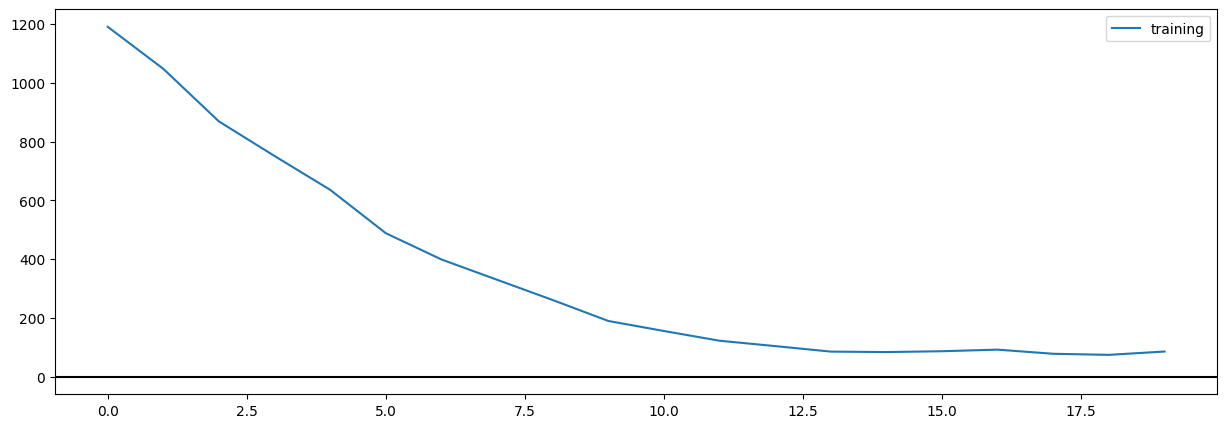

In [94]:
plt.figure(figsize=(15,5))
sns.lineplot(x=list(range(len(training_cost))) ,y=training_cost, label='training')
plt.axhline(0, color='black')

In [110]:
test_data = data.iloc[val_end:].reset_index(drop=True)

test_pred_out_lst = []

prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
for row_num in range(len(test_data)):
    test_input = torch.tensor(test_data.iloc[row_num][FEAT_COLS].to_list()).unsqueeze(1)
    test_tgt = torch.tensor(test_data.iloc[row_num][TGT_COLS].to_list()).unsqueeze(1)
    test_pred_out, prev_resev_state = model(input_data=input_data, prev_res_state=prev_resev_state)
    prev_resev_state= prev_resev_state.detach()

    test_pred_out_lst.append(test_pred_out.detach().numpy()[0][0])

test_data['pred_val'] = test_pred_out_lst


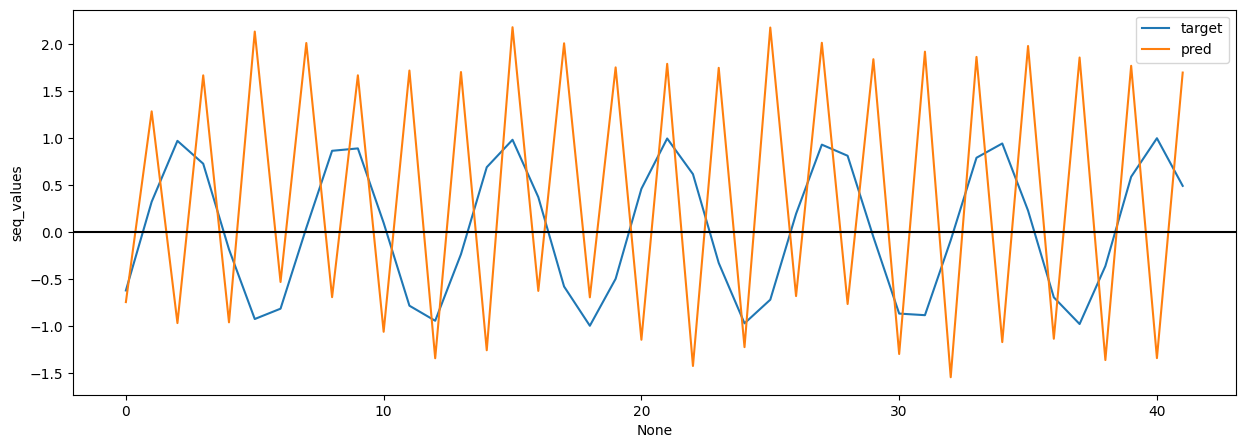

In [112]:
plt.figure(figsize=(15,5))

sns.lineplot(data=test_data,x=test_data.index, y='seq_values', label='target')
sns.lineplot(data=test_data,x=test_data.index, y='pred_val', label='pred')

plt.axhline(0, color='black')